<h1>How to analyze T-maze EEG-fMRI data</h1>

<h2>EEG cleaning and ICA</h2>

<p>Basic EEG preprocessing for data recorded in the MRI scanner
with some quality control measures</p>

In [1]:
%%capture
import mne

from mne.preprocessing import ICA
from mne.preprocessing import create_ecg_epochs, corrmap

import os
import glob

import numpy as np
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import pylab as pl

I do the first few pre-processing steps for gradient artifacts in matlab
You can find the script here:
https://github.com/MalteGueth/EEG_fMRI_tmaze/tree/master/adaptive_gradient_correction

So start by importing the already converted raw data (from .mff to .fif)

In [39]:
%%capture
os.chdir('/Volumes/INTENSO/EEG_fMRI_tmaze') # Set the working directory
file = './raw/pilot01_mr_corrected-raw.fif' # Pick the file

montage = mne.channels.read_montage(kind='GSN-HydroCel-256')
raw = mne.io.read_raw_fif(file, preload=True) # Create a raw object to work on and load it into memory

The channel types, positions and other aspects are a little off 
or impractical as they are here, so I build a new info file with a digital montage
Note that electrode E257 has no position, because it is the online reference (Cz equivalent)

In [40]:
raw.drop_channels(ch_names=['E257'])

s_freq = 1000
labels = raw.info['ch_names']
ch_types = list(['eeg']*256)
ch_types.append('ecg')
ch_types.append('stim')
meas_date=raw.info['meas_date']

info = mne.create_info(labels, s_freq, ch_types, montage)

info['buffer_size_sec']=1
info['meas_date']=meas_date
raw.info = info

A lot of the channels in the net are positioned on the cheek and the jaw,
so they are rather emg or in some cases eog channels.
That's why I'm just using a selection of EEG channels.

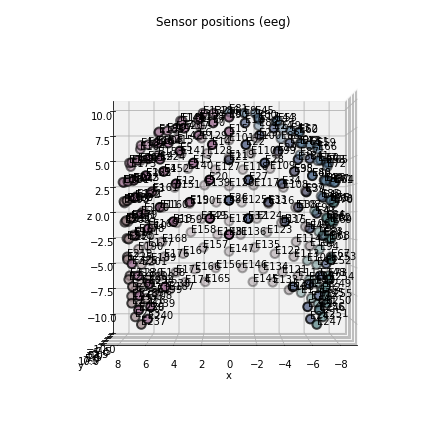

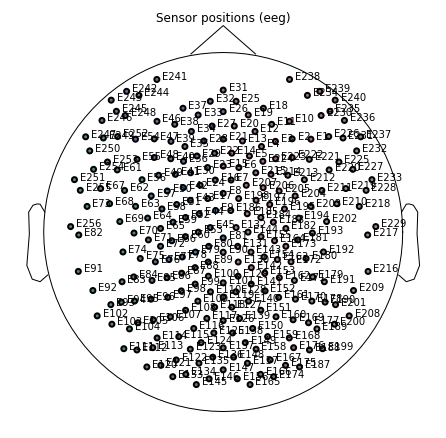

In [41]:
# Plot the montage with all channel names and positions that are included
# as EEG channels...
# ... as a 3D model

raw.copy().plot_sensors(kind='3d', ch_groups='position', show_names=True);
# ... as 2D topomap

raw.copy().plot_sensors(kind='topomap', ch_groups='position', show_names=True);

# It's slightly shifted in the head surface
# I haven't fixed that issue yet

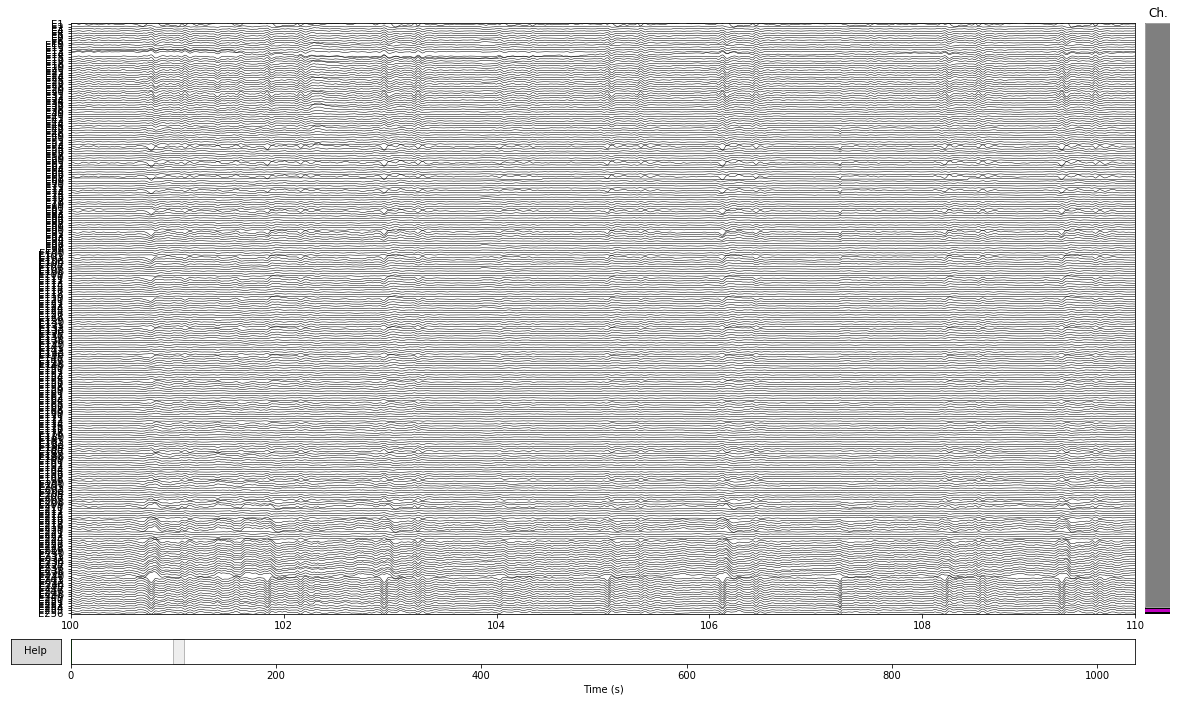

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz
Filter length of 16384 samples (16.384 sec) selected
Number of ECG events detected : 833 (average pulse 48 / min.)
833 matching events found
No baseline correction applied
Not setting metadata
Loading data for 833 events and 1001 original time points ...
0 bad epochs dropped


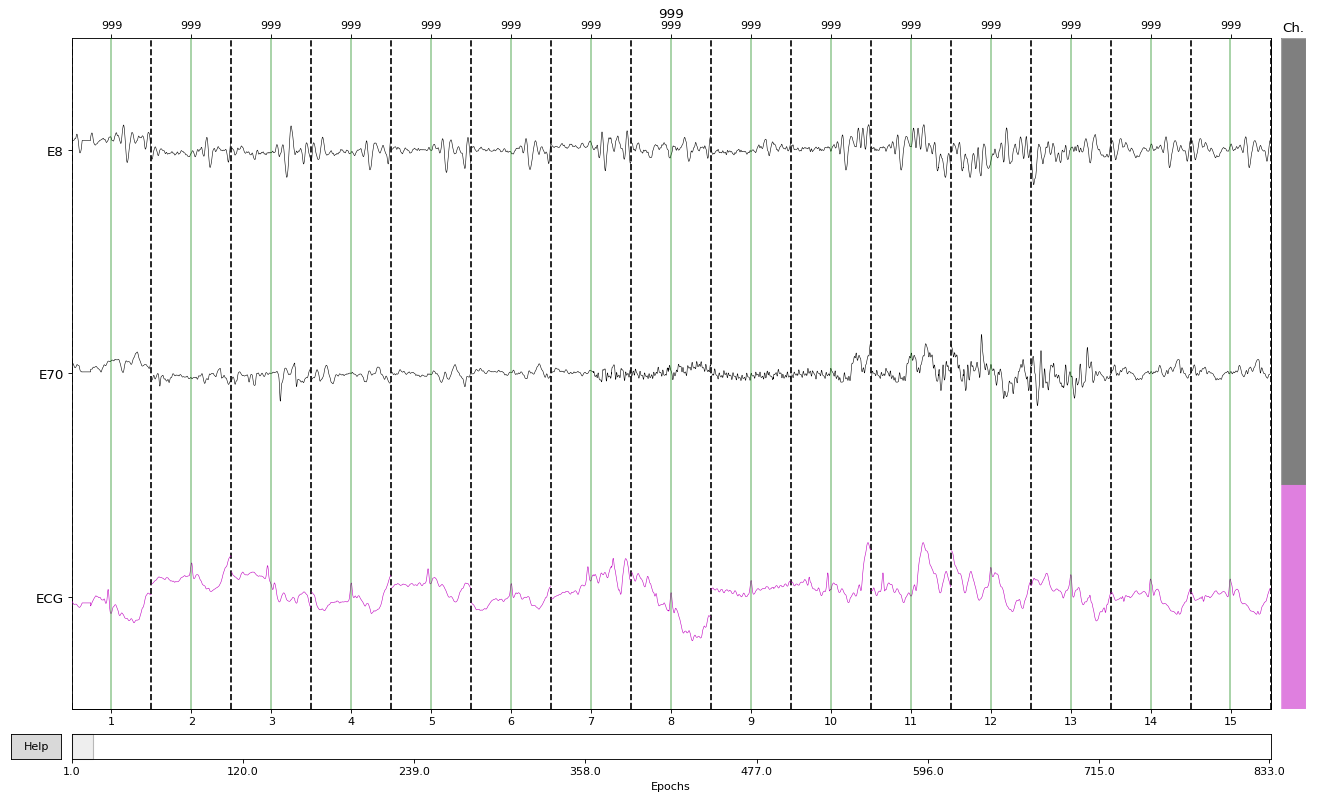

In [12]:
# Now plot 10 seconds of the raw data during the first block for all EEG channels

raw.plot(duration=10, start=100, scalings=dict(eeg=100e-6), n_channels=256)

# Add a new plot just for the ECG with some ECG channel, in order to highligh
# ballistocardiac artifacts
# Note that E8 is a frontocentral position and E70 is right above the ear
# and ballistocardiac artifacts tend to be stronger on temporal positions

ecg_epochs = create_ecg_epochs(raw, reject=None) # Perform a quick segmentation around heart beat events ECG
ecg_epochs.copy().pick_channels(['E8','E70','ECG']).plot(n_epochs=15,scalings=dict(eeg=200e-6,ecg=2000e-6),
                                                                n_channels=6)
plt.close()

# An automatic peak detection is run to time-lock (-0.5 and 0.5 around the peak) epochs
# Artifacts have their onset right after the R-peak (green line) of the QRS complex during 
# the ejection phase of the ECG (roughly the interval between the S and T component, 
# larger deflection in the ECG after the time-locked peak)

Looking alright!
Compare that to the uncorrected data with all the gradient artifacts

Opening raw data file /Volumes/INTENSO/EEG_fMRI_tmaze/raw/pilot_uncorrected-raw.fif...
    Range : 0 ... 1036805 =      0.000 ...  1036.805 secs
Ready.


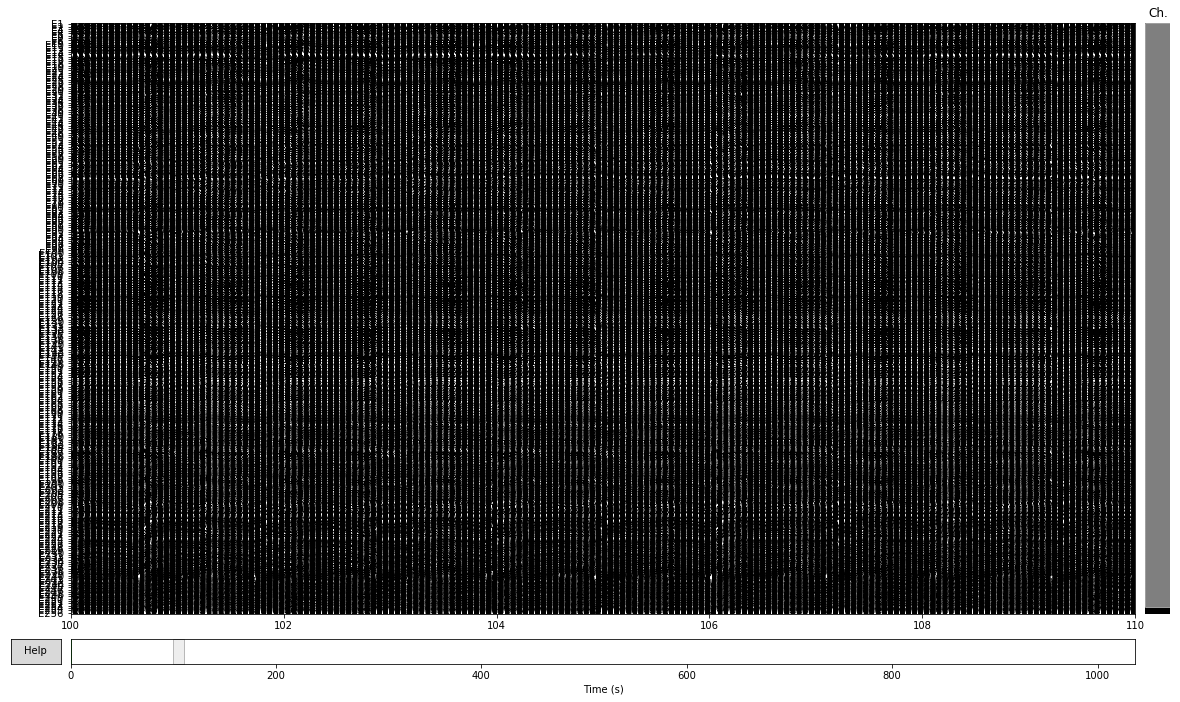

In [14]:
uncorrected ='./raw/pilot_uncorrected-raw.fif'
uncorrected = mne.io.read_raw_fif(uncorrected, preload=False)
uncorrected.plot(duration=10, start=100, scalings=dict(eeg=100e-6), n_channels=256)
plt.close()

Yikes, so that seems to have worked out ok. Next step is filtering
and re-referencing to an average reference (mean of all eeg channels).

First check the power spectrum density to get a feel for
artifact frequencies.

Effective window size : 2.048 (s)


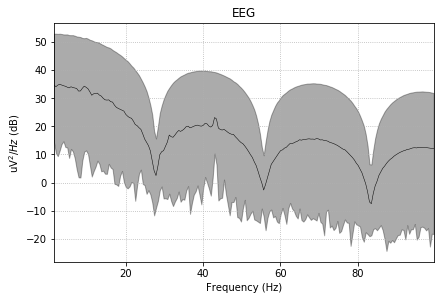

Setting up band-pass filter from 1 - 60 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 15.0 Hz
Filter length of 3301 samples (3.301 sec) selected
Effective window size : 2.048 (s)


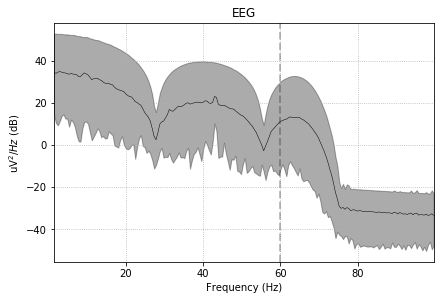

In [42]:
raw.plot_psd(area_mode='range', tmax=10.0, 
             average=True,
             fmin=1, fmax=100);

# ... and one more time after band-pass filtering between 0.1 and 50 Hz
raw.filter(1,60,fir_design='firwin')
raw.plot_psd(area_mode='range', tmax=10.0, 
             average=True,
             fmin=1, fmax=100);

In [45]:
# That's better, so now moving on to our new reference
raw.set_eeg_reference(ref_channels=['E190','E94'])

# Next, collect all the parameters necessary to run an ICA
# For demonstrational purposes decrease the sample points,
# set the number of components to 40 and pick a faster algorithm
# as method argument
n_components = 60  
method = 'extended-infomax'
decim = 10
reject = None

ica = ICA(n_components=n_components, method=method) 

Applying a custom EEG reference.


Also, to prevent slow drifts from biasing the ICA, filter a copy
of the signal with another band-pass and use the back-projection
later on the original signal

Start the ICA. This may take a while depending on the amount of data (sampling rate, duration of recording, number of electrodes).

In [11]:
%%capture
ica.fit(raw.copy().filter(1,30), picks=None, decim=decim, reject=reject)

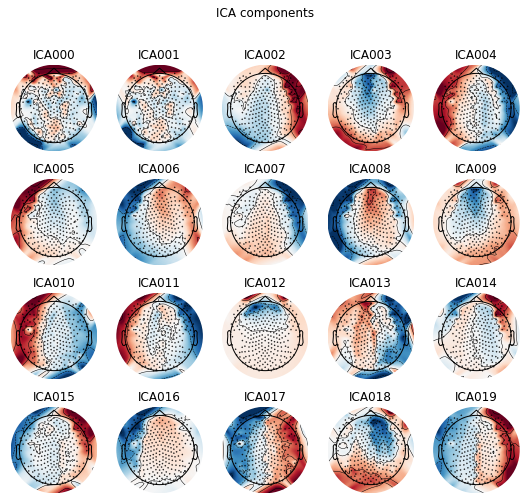

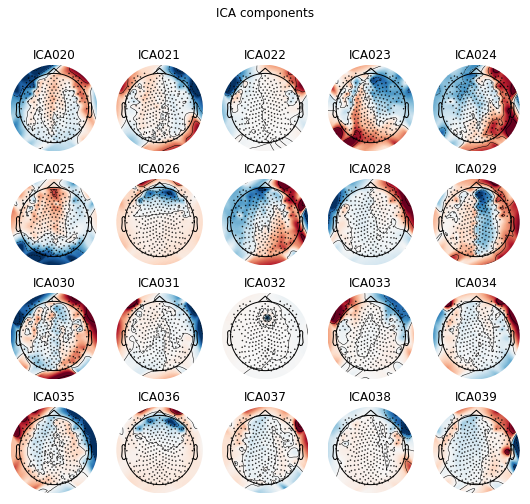

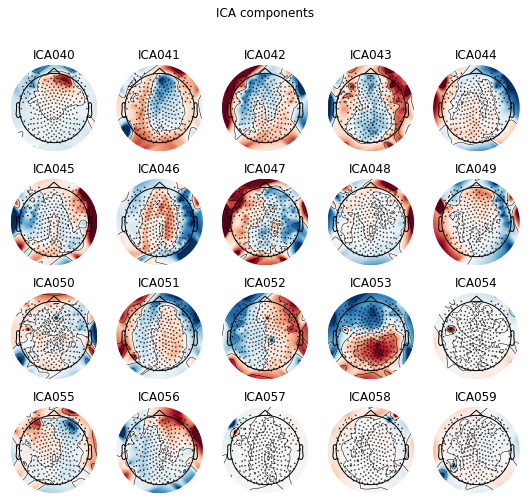

[<Figure size 540x504 with 20 Axes>,
 <Figure size 540x504 with 20 Axes>,
 <Figure size 540x504 with 20 Axes>]

In [5]:
# Plot the extracted signal components
ica.plot_components(outlines='skirt')

To best interpret components connected to heart beat, let's visualize the average heart beat along with the average EEG response time-locked to it.

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz
Filter length of 16384 samples (16.384 sec) selected
Number of ECG events detected : 1250 (average pulse 72 / min.)
1250 matching events found
No baseline correction applied
Not setting metadata
Loading data for 1250 events and 1001 original time points ...
0 bad epochs dropped


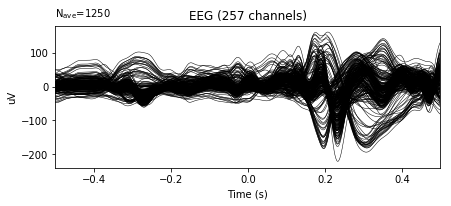

In [41]:
ecg_average = create_ecg_epochs(raw, reject=None).average()
ecg_average.plot()
plt.close()

Let's look at some typical ballistocardiac artifacts and a likely signal
component (topography, frequency spectrum, variance, etc) along with their
source signals and the ECG channel

### See anything that might look like heart beats in the first 14 components?

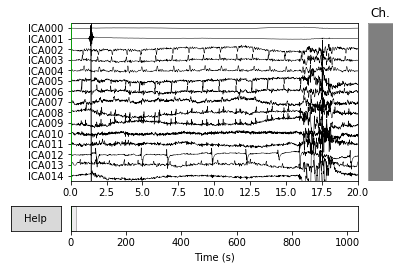

    Using multitaper spectrum estimation with 7 DPSS windows


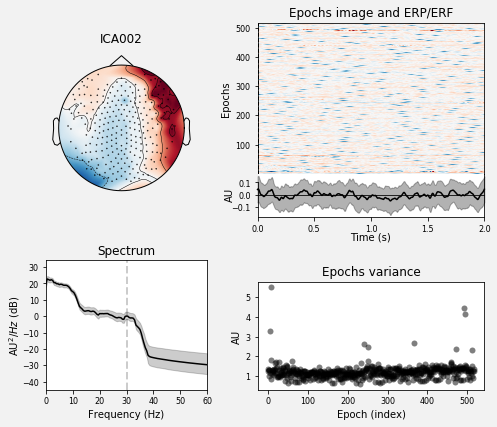

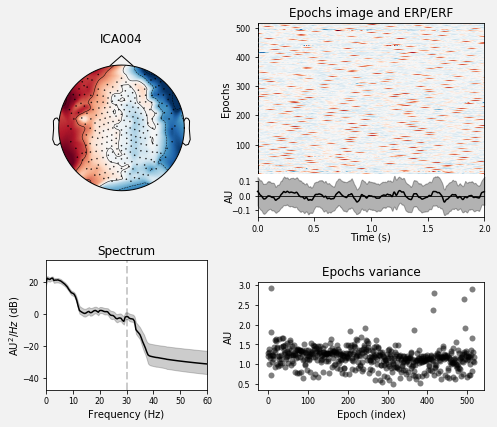

In [7]:
ica.plot_sources(raw, picks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

# We can have a closer look at their properties
ica.plot_properties(raw, picks=[2,4], psd_args={'fmax': 60.})
plt.close()

To find components reflecting ballistocardiac artifacts, correlate
the ECG signal with the continuous contribution of single ICA 
components

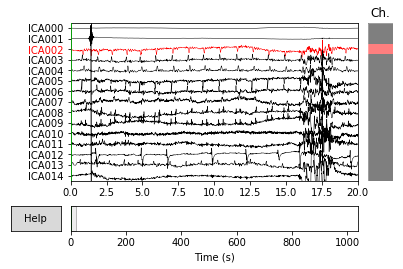

In [8]:
corr = lambda x, y: np.array([pearsonr(a, y.ravel()) for a in x])[:, 0]

# The find_sources method returns and array of correlation
# scores for each ICA source.
ecg_scores = ica.score_sources(raw, target='ECG', score_func=corr)

# Get the component index of the maximum correlation with the ECG
ecg_source_idx = np.abs(ecg_scores).argmax()

# Mark the source with the maximum correlation
ica.plot_sources(raw, exclude=[ecg_source_idx], picks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.close()

Alternatively, we can threshold and plot the component
scores for every ICA component based on cross-trial phase statistics

In [4]:
%%capture
# Create ECG epochs around likely artifact events and average them 

ecg_average = create_ecg_epochs(raw, reject=None).average()

# Create ECG epochs around likely artifact events and correlate them
# to all ICA component source signal time course
# Build artifact scores via the correlation anaylsis
ecg_epochs = create_ecg_epochs(raw, reject=None)
ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, threshold=0.2, method='ctps')

Plot the artifact scores / correlations across ICA components
and retrieve component numbers of sources likely representing
caridoballistic artifacts

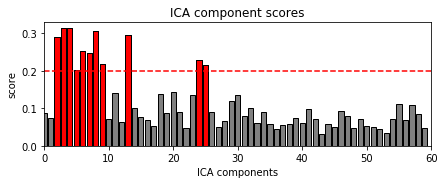

In [16]:
ica.plot_scores(scores, title='ICA component scores',
                exclude=ecg_inds, # Mark the identified cardiac artifact components red
                show=True, 
                axhline=0.2) # Plot a horizontal line to mark the score threshold
plt.close()

To improve your selection, inspect the ica components' 
source signal time course and compare it to the average ecg artifact 

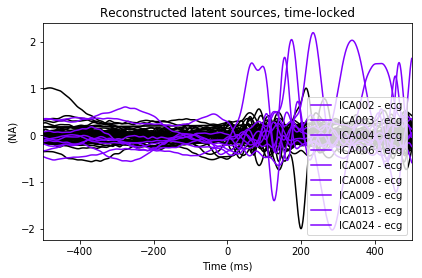

Transforming to ICA space (60 components)
Zeroing out 9 ICA components


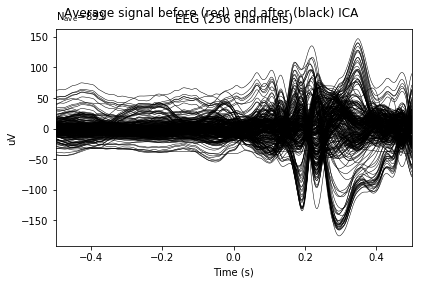

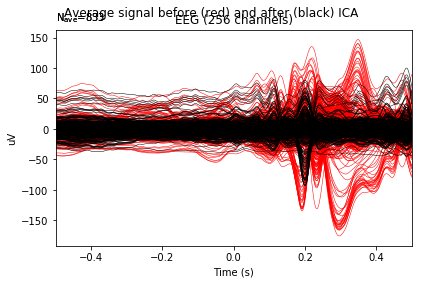

In [12]:
ica.plot_sources(ecg_average, exclude=ecg_inds)

# Also, overlay the raw data with the cleaned signal (given the artifact indices)
ica.plot_overlay(ecg_average, exclude=ecg_inds)

There is one more way how you can improve your ICA-based correction,
which is by validating single subject ICA decompositions with a 
shared reference ICA

Reading ica\tmaze01_prepro60-ica.fif ...
Now restoring ICA solution ...
Ready.
Reading ica\tmaze02_prepro60-ica.fif ...
Now restoring ICA solution ...
Ready.
Reading ica\tmaze03_prepro60-ica.fif ...
Now restoring ICA solution ...
Ready.


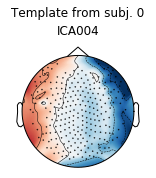

Median correlation with constructed map: 0.940
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


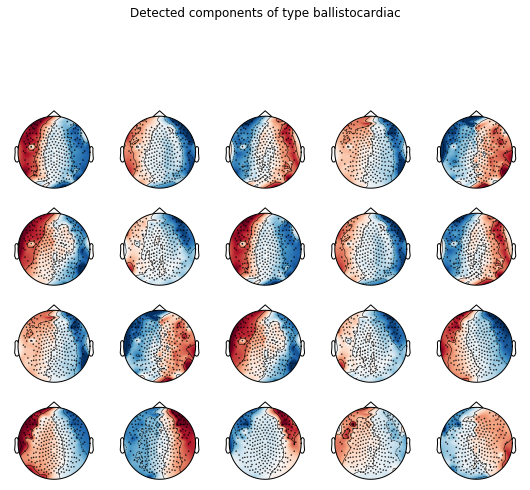

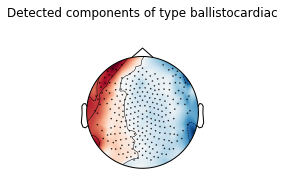

In [17]:
# Loop through all the subjects (right now, only two...) to load 
# them in and append in a list
icas_subjects = list()

# The same pre-processing pipeline was run on our second subject
# whose ICA decomposition is now loaded into memory

path_ica = 'ica\\'
for ica_file in glob.glob(os.path.join(path_ica, '*60-ica.fif')):
  
    current_ica = mne.preprocessing.read_ica(ica_file)
    icas_subjects.append(current_ica)

reference_ica = icas_subjects[0] # Pick the first subject as a reference ICA
                                 # The reference should usually be one with particulalry well
                                 # identified components
all_icas = [reference_ica] + icas_subjects

# Build a tuple with the reference ica and the index of the representative
# component that is to form the template
cardio_template = (0, ecg_inds[1])
    
# Run the corrmap algorithm to compare the artifact template to all other 
# components from the remaining subjects
# Find all components that correlate to the template

fig_template, fig_detected = corrmap(all_icas, template=cardio_template,threshold=.9, 
                                     label="ballistocardiac", show=True)

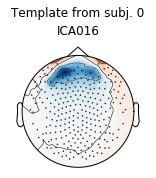

Median correlation with constructed map: 0.932
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


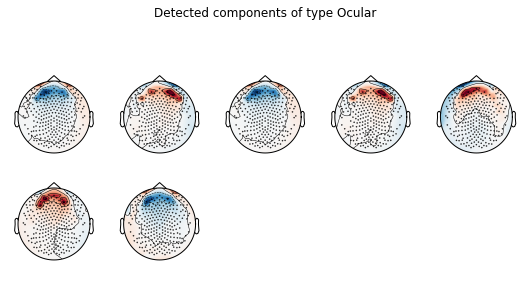

In [16]:
# and eyes ...
eye_template = (0, 16)
    
# Run the corrmap algorithm to compare the artifact template to all other 
# components from the remaining subjects
# Find all components that correlate to the template

fig_template, fig_detected = corrmap(all_icas, template=eye_template,threshold=.8, 
                                     label="Ocular", show=True)

Reading ica\tmaze01_prepro60-ica.fif ...
Now restoring ICA solution ...
Ready.
Reading ica\tmaze02_prepro60-ica.fif ...
Now restoring ICA solution ...
Ready.
Reading ica\tmaze03_prepro60-ica.fif ...
Now restoring ICA solution ...
Ready.


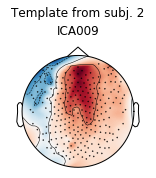

Median correlation with constructed map: 0.956
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


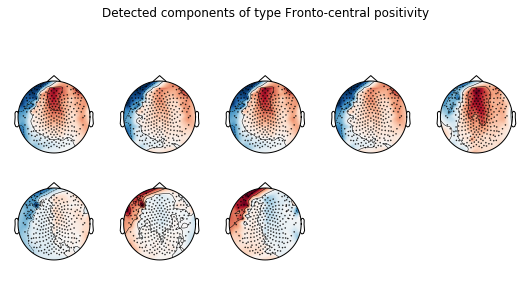

In [15]:
# The same for the reward positivity...
rp_template = (2, 9)
    
# Run the corrmap algorithm to compare the artifact template to all other 
# components from the remaining subjects
# Find all components that correlate to the template

fig_template, fig_detected = corrmap(all_icas, template=rp_template,threshold=.9, 
                                     label="Fronto-central positivity", show=True)

Depending on the template results, adjust the indices collected from
the ECG analysis (i.e., correct only intersection between the two)

If no fruther refinement of the artifact selection is required, add
components reflecting different kind of artifacts (blinks, saccades),
back-project the non-artifact components to the mixed, continuous signal
Enter an array of bad indices to zero out components
start and end arguments can mark the first and last sample of the set to be
affected by the back-projection

Reading ica\tmaze01_prepro60-ica.fif ...
Now restoring ICA solution ...
Ready.
Opening raw data file D:\EEG_fMRI_tmaze\raw\tmaze01_prepro-raw.fif...
    Range : 0 ... 1036983 =      0.000 ...  1036.983 secs
Ready.
Reading 0 ... 1036983  =      0.000 ...  1036.983 secs...
Transforming to ICA space (60 components)
Zeroing out 29 ICA components


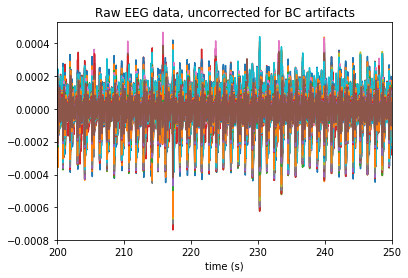

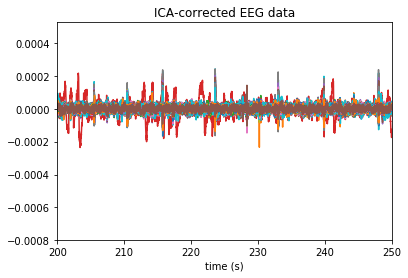

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz
Filter length of 16384 samples (16.384 sec) selected
Number of ECG events detected : 951 (average pulse 55 / min.)
951 matching events found
No baseline correction applied
Not setting metadata
Loading data for 951 events and 1001 original time points ...
0 bad epochs dropped


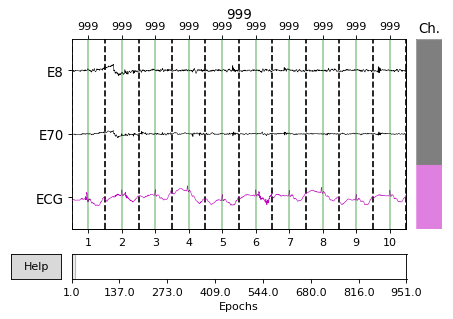

In [35]:
raw_ica = ica.apply(raw.copy(), exclude=ecg_inds)

# Compare the ICA pre-processed version with the previous pre-processing stage
start, stop = raw.time_as_index([200, 250])
data, times = raw[0:256, start:stop]
data_clean, _ = raw_ica[0:256, start:stop]

# Raw data without ICA correction
pl.figure()
pl.plot(times, data.T)
pl.xlabel('time (s)')
pl.xlim(200, 250)
pl.title('Raw EEG data, uncorrected for BC artifacts')
y0, y1 = pl.ylim()

# ICA-corrected data
pl.figure()
pl.plot(times, data_clean.T)
pl.xlabel('time (s)')
pl.xlim(200, 250)
pl.title('ICA-corrected EEG data')
pl.ylim(y0, y1)
pl.show()

# Perform another quick segmentation around heart beat events ECG after the ICA correction
ecg_epochs = create_ecg_epochs(raw_ica, reject=None)
ecg_epochs.copy().pick_channels(['E8','E70','ECG']).plot(n_epochs=10,scalings=dict(eeg=100e-6,ecg=2000e-6),
                                                         n_channels=6);

### Finally, save all your results in fif format and the appropriate ending

In [ ]:
%%capture
raw.save('./raw/sub01_ICA-raw.fif')
ica.save('./ica/sub01-ica.fif')